### Descriptive Statistics

Scenario:

You are a data analyst at an e-commerce company that sells a variety of products. Your company wants to better understand how various products perform across regions, in order to devise its sales strategy for next year.

You have been provided with data includes information about the product, the region where the product was sold, the price of the product, the number of units sold, and the date of the sale.

Your task is to clean the data as you see fit, and conduct exploratory analysis which will help the company build a sales strategy for the following year.

In addition to the analysis, be sure to answer the following questions:

1) What conclusions can you draw about sales performance of various products and regions?

2) What recommendations do you have for the business?

3) Describe your data cleaning approach. How and why did you decide on which cleaning techniques to use?

### Importing libraries

For this analysis, we can use Pandas and Seaborn to analyze and visualize our data. This will help us identify data issues, find insights, and visualize any patterns or trends.

In [79]:
import pandas as pd
import seaborn as sns

In [80]:
df = pd.read_csv('https://raw.githubusercontent.com/offcial17/schulich_data_science/main/Datasets/sales_data.csv')
df

,Product,Region,Price,Units Sold,Sale Date
0,NaN,Region_1,72.87,10.0,2022-01-01
1,Product_40,Region_2,46.19,10.0,2022-01-02
2,Product_1,Region_5,NaN,4.0,2022-01-03
3,Product_6,Region_8,143.47,8.0,2022-01-04
4,Product_44,Region_4,122.54,10.0,2022-01-05
...,...,...,...,...,...
1045,Product_42,Region_3,18.63,9.0,2023-07-10
1046,Product_4,Region_3,159.27,10.0,2024-07-14
1047,Product_43,Region_1,2.91,13.0,2023-08-17
1048,Product_27,Region_7,1.96,8.0,2024-03-10


### Assessing the DataFrame

* In this case, we see that we have a categorical column called Product - this seems to refer to a product identifier. 
* We also have a categorical column called Region, which seems to refer to a Region identifier. 
* We a numerical column called Price - it's not clear whether this is the total order price, or the unit price. Here, we will make an assumption - absent any details, we'll assume this is the Unit Price.
* We also have a numerical column called Units Sold - this looks like the total units of the order. 
* Finally, we have a Sale Date column which seems to have the day by day details of each sale.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     947 non-null    object 
 1   Region      942 non-null    object 
 2   Price       945 non-null    float64
 3   Units Sold  943 non-null    float64
 4   Sale Date   1050 non-null   object 
dtypes: float64(2), object(3)
memory usage: 41.1+ KB


In [82]:
missing_values = df.isnull().sum()
duplicated  = df.duplicated().sum()
datatypes  = df.dtypes
unqiue = df.nunique()

columns  = pd.DataFrame({
    "missing_values":missing_values,
    "duplicated":duplicated,
    "datatypes":datatypes,
    "unqiue":unqiue,
})

columns

,missing_values,duplicated,datatypes,unqiue
Product,103,49,object,50
Region,108,49,object,10
Price,105,49,float64,883
Units Sold,107,49,float64,21
Sale Date,0,49,object,1000


* We can see that out of 1050 entries, only the Sale Data has a complete data set
* Product has (1050-947) = 103 missing data points, or roughly 10% missing data
* Region has (1050-942) = 108 missing data points, or roughly 10% missing data
* Price has (1050-945) = 105 missing data points, or exactly 10% missing data
* Units Sold has (1050-943) = 107 missing data points, or roughly 10% missing data

While each column has roughly 10% missing data, collectively there is about 40% of missing data.

In [83]:
df.describe(include='all')

,Product,Region,Price,Units Sold,Sale Date
count,947,942,945.000000,943.000000,1050
unique,50,10,NaN,NaN,1000
top,Product_4,Region_5,NaN,NaN,2023-07-31
freq,30,112,NaN,NaN,2
mean,NaN,NaN,108.628011,10.200424,NaN
std,NaN,NaN,167.350086,3.247589,NaN
min,NaN,NaN,0.190000,2.000000,NaN
25%,NaN,NaN,26.420000,8.000000,NaN
50%,NaN,NaN,64.640000,10.000000,NaN
75%,NaN,NaN,142.310000,12.000000,NaN


Now let's look at some initial descriptive statistics to understand what our data looks like. We can use the describe() function. We are adding an include='all' parameter because we have categorical data. We can see the following:
* Product has 50 unique values, with Product_4 being the most frequently occuring product, with 30 entries (~3% of all data)
* Region has 10 unique values, with Region_5 being the most frequently occuring region, with 112 entries (~10% of all data)
* The median Price is $64 while the mean Price is $108, which indicates skewness
* The maximum Price is $2,636 - this could be an outlier. We will need to investigate
* The median Units Sold is 10 and the mean Units Sold is also 10, which indicates a normal distribution
* The Sale Date has 1000 unique values, with the top value being '2023-07-31' occurring twice

### Data Cleaning
Now we will clean our data. Earlier we concluded we have too many missing values to simply drop them, so we should try to impute. Let's devise a cleaning plan:
* We don't see any data type issues, with the exception of Sale Date, which is currently an 'object'. This should be a datetime data type.
* First, we should check if there are any rows where all 4 columns have a missing data point; these rows we should drop immediately.
* Product: since the mode is only 3% of the data, and we have roughly 10% missing data, we may create bias by imputing with the mode. A good strategy here would be to either randomly assign Product values, or to use "Other"
* Region: since the mode is 10% of the data, and we have roughly 10% missing data, as with Product we could create bias by imputing with the mode. We will take a similar approach as above
* Price: since the data is skewed, we should either use the median() of the column, or use the median() by Product - this would likely give us a more accurate estimate
* Units Sold: since the data is normally distributed, we could use the mean() or we could try using the mean() by Product or Region


Let's test this plan and identify the best approach by comparing a cleaned DataFrame to our original statistics. We don't want to change the original characteristics too much to preserve the integrity of the data we do have.

Let's start by identifying rows where all data points are missing.

In [84]:
# We can use a simple filter to check if any row has all column data missing

df[df['Product'].isnull() & df['Region'].isnull() & df['Price'].isnull() & df['Units Sold'].isnull()]

,Product,Region,Price,Units Sold,Sale Date


In [85]:
# The above yielded no rows, let's check situations where we have Product & Region & Price
df[df['Product'].isnull() & df['Region'].isnull() & df['Price'].isnull()]

,Product,Region,Price,Units Sold,Sale Date
7,NaN,NaN,NaN,11.0,2022-01-08


In [86]:
# We have 1 row with Product, Region and Price missing. Let's check Product, Region and Units Sold
df[df['Product'].isnull() & df['Region'].isnull() & df['Units Sold'].isnull()]

,Product,Region,Price,Units Sold,Sale Date
22,NaN,NaN,36.26,NaN,2022-01-23


In [87]:
# Both observations 7 and 22 should be deleted, as too much data is missing. Let's drop these using drop()
df.drop([7,22], axis=0, inplace=True)

In [88]:
# Let's check remaining observations with both Product and Region missing
df[df['Product'].isnull() & df['Region'].isnull()]

,Product,Region,Price,Units Sold,Sale Date
43,NaN,NaN,13.59,12.0,2022-02-13
228,NaN,NaN,24.35,10.0,2022-08-17
304,NaN,NaN,9.43,7.0,2022-11-01
318,NaN,NaN,305.21,9.0,2022-11-15
362,NaN,NaN,292.85,9.0,2022-12-29
604,NaN,NaN,49.04,13.0,2023-08-28
706,NaN,NaN,184.50,6.0,2023-12-08
842,NaN,NaN,200.61,12.0,2024-04-22
1006,NaN,NaN,292.85,9.0,2022-12-29
1016,NaN,NaN,200.61,12.0,2024-04-22


In [89]:
# We have 10 remaining observations who likely have too much data missing, this is a small number so we can drop them
# using the index values
df.drop(df[df['Product'].isnull() & df['Region'].isnull()].index, axis=0, inplace=True)

In [90]:
# Let's check our data statistics now
df.describe(include='all')

,Product,Region,Price,Units Sold,Sale Date
count,947,942,934.000000,932.000000,1038
unique,50,10,NaN,NaN,990
top,Product_4,Region_5,NaN,NaN,2023-05-18
freq,30,112,NaN,NaN,2
mean,NaN,NaN,108.184336,10.202790,NaN
std,NaN,NaN,167.810334,3.258414,NaN
min,NaN,NaN,0.190000,2.000000,NaN
25%,NaN,NaN,26.442500,8.000000,NaN
50%,NaN,NaN,64.620000,10.000000,NaN
75%,NaN,NaN,141.150000,12.000000,NaN


After checking the describe function, we see our medians, means, and modes have not changed. This makes sense, since we have simply dropped data points which were not part of these calculations. We can also check our info() function and see that our data set has been reduced by 12 entries.

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     947 non-null    object 
 1   Region      942 non-null    object 
 2   Price       934 non-null    float64
 3   Units Sold  932 non-null    float64
 4   Sale Date   1038 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.7+ KB


Now let's check what would happen if we fill in missing Product and Region data with "Other". First, we'll make a copy of our DataFrame - we want to test the output of this approach before making a final decision.

In [92]:
# Use the copy() function to make a copy of the DataFrame
df_test = df.copy()

In [93]:
# Obtain descriptive statistics by Region using groupby()
df_test.groupby('Region').describe()

Price                                                            
           count        mean         std   min      25%     50%       75%   
Region                                                                      
Region_1    78.0   97.792821   89.277140  2.91  40.7575  72.440  121.2150  \
Region_10   80.0  113.310500  120.292908  0.19  26.7425  67.900  151.6175   
Region_2    94.0  137.287340  283.069362  1.49  24.4725  66.960  158.7025   
Region_3    75.0   91.008400   89.612608  3.40  35.1000  58.370  121.1550   
Region_4    79.0   85.824051   94.673327  2.37  21.3050  47.340  119.8500   
Region_5   100.0  125.430300  263.248626  0.27  31.6175  75.195  141.4850   
Region_6    81.0   96.727037   98.491166  0.71  28.7300  55.410  125.5100   
Region_7    84.0  107.210119  211.396135  0.19  20.1225  58.865  123.8175   
Region_8    88.0  120.850909  158.015038  0.27  38.8225  81.585  145.4825   
Region_9    88.0   95.861477   98.457933  0.25  23.6950  66.375  134.7675   

                   Units Sold                                                
               max      count       mean       std  min   25%   50%    75%   
Region                                                                       
Region_1    469.65       82.0  10.329268  3.527860  2.0  8.00  10.5  13.00  \
Region_10   650.50       81.0   9.814815  3.369388  4.0  8.00  10.0  12.00   
Region_2   2636.90       92.0  10.413043  2.875253  5.0  8.75  10.0  12.00   
Region_3    485.84       78.0   9.807692  3.137779  4.0  8.00  10.0  11.75   
Region_4    489.40       79.0  10.227848  3.108918  2.0  8.00  10.0  12.00   
Region_5   2544.60      103.0   9.941748  3.333800  3.0  7.00  10.0  12.00   
Region_6    417.05       71.0  10.394366  2.983186  4.0  9.00  10.0  12.00   
Region_7   1793.90       85.0  10.894118  3.712987  3.0  8.00  11.0  13.00   
Region_8   1296.00       84.0  10.642857  3.364030  3.0  8.75  11.0  12.25   
Region_9    531.91       89.0   9.887640  2.994078  5.0  7.00  10.0  12.00   

                 
            max  
Region           
Region_1   21.0  
Region_10  19.0  
Region_2   17.0  
Region_3   18.0  
Region_4   16.0  
Region_5   18.0  
Region_6   18.0  
Region_7   22.0  
Region_8   20.0  
Region_9   18.0

In [94]:
# Fill in missing Region data with "Other" and compare statistics
df_test['Region'] = df_test['Region'].fillna('Other')

In [95]:
df_test.groupby('Region').describe()

Price                                                            
           count        mean         std   min      25%     50%       75%   
Region                                                                      
Other       87.0  107.890690  117.639895  1.46  21.4350  56.250  162.3150  \
Region_1    78.0   97.792821   89.277140  2.91  40.7575  72.440  121.2150   
Region_10   80.0  113.310500  120.292908  0.19  26.7425  67.900  151.6175   
Region_2    94.0  137.287340  283.069362  1.49  24.4725  66.960  158.7025   
Region_3    75.0   91.008400   89.612608  3.40  35.1000  58.370  121.1550   
Region_4    79.0   85.824051   94.673327  2.37  21.3050  47.340  119.8500   
Region_5   100.0  125.430300  263.248626  0.27  31.6175  75.195  141.4850   
Region_6    81.0   96.727037   98.491166  0.71  28.7300  55.410  125.5100   
Region_7    84.0  107.210119  211.396135  0.19  20.1225  58.865  123.8175   
Region_8    88.0  120.850909  158.015038  0.27  38.8225  81.585  145.4825   
Region_9    88.0   95.861477   98.457933  0.25  23.6950  66.375  134.7675   

                   Units Sold                                                
               max      count       mean       std  min   25%   50%    75%   
Region                                                                       
Other       570.60       88.0   9.931818  3.303761  3.0  7.00  10.0  12.00  \
Region_1    469.65       82.0  10.329268  3.527860  2.0  8.00  10.5  13.00   
Region_10   650.50       81.0   9.814815  3.369388  4.0  8.00  10.0  12.00   
Region_2   2636.90       92.0  10.413043  2.875253  5.0  8.75  10.0  12.00   
Region_3    485.84       78.0   9.807692  3.137779  4.0  8.00  10.0  11.75   
Region_4    489.40       79.0  10.227848  3.108918  2.0  8.00  10.0  12.00   
Region_5   2544.60      103.0   9.941748  3.333800  3.0  7.00  10.0  12.00   
Region_6    417.05       71.0  10.394366  2.983186  4.0  9.00  10.0  12.00   
Region_7   1793.90       85.0  10.894118  3.712987  3.0  8.00  11.0  13.00   
Region_8   1296.00       84.0  10.642857  3.364030  3.0  8.75  11.0  12.25   
Region_9    531.91       89.0   9.887640  2.994078  5.0  7.00  10.0  12.00   

                 
            max  
Region           
Other      19.0  
Region_1   21.0  
Region_10  19.0  
Region_2   17.0  
Region_3   18.0  
Region_4   16.0  
Region_5   18.0  
Region_6   18.0  
Region_7   22.0  
Region_8   20.0  
Region_9   18.0

In the above approach, we are comparing the characteristics of the "Other" region with the remaining regions. It seems that the statistics are quite similar. We have roughly 87 entries, the mean, standard deviation, distribution, median, and quartiles are in and around what the other Regions have, for both Price and Units Sold. I don't think this is creating much bias in our data. 

Now let's compare what happens if we use "Region_5", the mode, to fill in the data. We will make another test DataFrame.

In [96]:
df_test_2 = df.copy()

In [97]:
df_test_2['Region'] = df_test_2['Region'].fillna('Region_5')

In [98]:
df_test_2.groupby('Region').describe()

Price                                                            
           count        mean         std   min      25%     50%       75%   
Region                                                                      
Region_1    78.0   97.792821   89.277140  2.91  40.7575  72.440  121.2150  \
Region_10   80.0  113.310500  120.292908  0.19  26.7425  67.900  151.6175   
Region_2    94.0  137.287340  283.069362  1.49  24.4725  66.960  158.7025   
Region_3    75.0   91.008400   89.612608  3.40  35.1000  58.370  121.1550   
Region_4    79.0   85.824051   94.673327  2.37  21.3050  47.340  119.8500   
Region_5   187.0  117.270160  208.233263  0.27  26.8850  68.150  151.5300   
Region_6    81.0   96.727037   98.491166  0.71  28.7300  55.410  125.5100   
Region_7    84.0  107.210119  211.396135  0.19  20.1225  58.865  123.8175   
Region_8    88.0  120.850909  158.015038  0.27  38.8225  81.585  145.4825   
Region_9    88.0   95.861477   98.457933  0.25  23.6950  66.375  134.7675   

                   Units Sold                                                
               max      count       mean       std  min   25%   50%    75%   
Region                                                                       
Region_1    469.65       82.0  10.329268  3.527860  2.0  8.00  10.5  13.00  \
Region_10   650.50       81.0   9.814815  3.369388  4.0  8.00  10.0  12.00   
Region_2   2636.90       92.0  10.413043  2.875253  5.0  8.75  10.0  12.00   
Region_3    485.84       78.0   9.807692  3.137779  4.0  8.00  10.0  11.75   
Region_4    489.40       79.0  10.227848  3.108918  2.0  8.00  10.0  12.00   
Region_5   2544.60      191.0   9.937173  3.311262  3.0  7.00  10.0  12.00   
Region_6    417.05       71.0  10.394366  2.983186  4.0  9.00  10.0  12.00   
Region_7   1793.90       85.0  10.894118  3.712987  3.0  8.00  11.0  13.00   
Region_8   1296.00       84.0  10.642857  3.364030  3.0  8.75  11.0  12.25   
Region_9    531.91       89.0   9.887640  2.994078  5.0  7.00  10.0  12.00   

                 
            max  
Region           
Region_1   21.0  
Region_10  19.0  
Region_2   17.0  
Region_3   18.0  
Region_4   16.0  
Region_5   19.0  
Region_6   18.0  
Region_7   22.0  
Region_8   20.0  
Region_9   18.0

Here we can see that the characteristics of Region 5 changed somewhat drastically. The average price changed from $125 to $117; the median price from $75 to $68. The unit characteristics seem mostly the same, with the exception of there being more observations. 

Based on this, it's better to create a new category called "Other" so we don't adjust the characteristics of the Price column. 
Let's go ahead and change the original DataFrame.

In [99]:
df['Region'] = df['Region'].fillna('Other')

Let's repeat the process now for the "Product" column. First let's check the characteristics with filling in with "Other" vs. "Product_4".

In [100]:
df_test['Product'] = df_test['Product'].fillna('Other')
df_test_2['Product'] = df_test_2['Product'].fillna('Product_4')

In [101]:
df_test.groupby('Product').describe()

Price                                                              
           count        mean         std    min      25%      50%       75%   
Product                                                                       
Other       81.0  132.646790  293.502959   0.27  17.9000   64.600  147.4700  \
Product_1   19.0   99.960526  108.592682   3.40  46.8550   75.880  107.4200   
Product_10  17.0   97.610588   77.320574   3.63  36.2400   85.330  121.6500   
Product_11  12.0  120.550833   98.670114  21.70  61.6225   78.720  142.3325   
Product_12  14.0   77.138571   65.900566   2.37  30.6700   62.570  108.5425   
Product_13  17.0   88.629412   85.923571  12.86  18.2100   54.910  145.8400   
Product_14  10.0   95.544000  140.334625   4.15  17.6350   40.905  102.9875   
Product_15  19.0   89.121053  102.348294   5.71  24.2300   39.720  140.4600   
Product_16  13.0   77.116154  104.202676   4.52  11.2800   46.950   91.9800   
Product_17  21.0  127.157143   88.934104   5.39  54.6500  120.080  180.6100   
Product_18  11.0  107.107273  117.847272   1.90  18.7450   97.780  139.1000   
Product_19  20.0  115.748500   82.634176  16.82  46.6175   96.925  158.4750   
Product_2   17.0   79.284706   98.867995   8.80  24.8000   41.140   96.0300   
Product_20  15.0  110.592000  124.964054   9.09  21.6200   39.860  171.7950   
Product_21  14.0  110.399286  133.127824   0.19  16.6725   67.730  138.1200   
Product_22  18.0  130.213889  125.527139   7.59  48.8050   74.380  179.3050   
Product_23  20.0  130.509000  104.763169  11.00  35.3175   95.435  202.5500   
Product_24  25.0   57.740000   49.101278   0.25  26.3100   46.870   63.8700   
Product_25  13.0   79.464615   83.116307   1.96  10.2000   56.250  100.5700   
Product_26  16.0   90.234375   98.076628   8.76  31.7475   49.835  137.0575   
Product_27  21.0  193.255238  391.650662   1.96  24.0900   59.150  160.3400   
Product_28  20.0   78.497500   80.023828   4.20  22.1250   46.810  110.6975   
Product_29  14.0   82.186429   58.486838  10.39  33.4250   65.570  117.2300   
Product_3   21.0   93.558095   98.864401   7.57  20.8100   42.790  113.4700   
Product_30  15.0   85.231333   99.109780   3.61  27.0900   52.600   88.0400   
Product_31  20.0  128.834500  111.157886   1.60  25.1600   81.490  247.0900   
Product_32  10.0   74.437000   69.775829   1.66  26.4850   50.895  120.5650   
Product_33  16.0  114.543125  108.220983   7.97  45.6575   69.925  129.0250   
Product_34  17.0  253.598235  618.111915  20.51  53.7500  124.300  165.0900   
Product_35  11.0   47.802727   20.363126  17.20  34.9750   47.160   61.4100   
Product_36  18.0  103.420556   95.675373   0.27  26.7350   93.855  141.7100   
Product_37  17.0  105.664706  125.155765   4.31  23.3500   39.440  145.1000   
Product_38  19.0  100.138947   65.591971   7.46  44.8300   86.840  135.0000   
Product_39  12.0  104.623333  102.858955   1.46  11.5225   70.400  224.4300   
Product_4   29.0   99.022414   85.759042   6.02  24.5200   74.250  147.7800   
Product_40  26.0  111.934615  140.208123   2.91  27.3675   48.795  120.8150   
Product_41  11.0   70.522727   59.472020  13.16  20.7550   60.560  101.2550   
Product_42  19.0   90.431579   74.030503  17.44  28.7150   75.390  135.2600   
Product_43  25.0   73.047600   63.950752   0.27  27.3800   61.050   91.8200   
Product_44  15.0  120.669333  137.578457   0.19  28.2650   83.330  116.2700   
Product_45  14.0  104.425714   88.948415   6.20  34.5400   86.365  152.4725   
Product_46  15.0  120.521333  125.516603   0.71  38.9150   87.660  133.6500   
Product_47  10.0   68.001000   44.358792  13.46  33.5250   59.535  112.5975   
Product_48  14.0   66.525714   67.226234   6.22  23.1050   51.840   73.0550   
Product_49  21.0  165.538095  268.610528  14.87  51.9300   96.060  168.3600   
Product_5   13.0   77.390000   69.412601   2.06  18.8000   49.530  150.8700   
Product_50  25.0  179.963600  156.803329  19.74  68.1600  144.470  223.8100   
Product_6   16.0   90.030000   89.634786  22.76  28.8200   63

Initially, we see that "Other" has a sufficiently higher product count than the rest of the products. Also the mean, stdev, and other metrics for Price seem to be quite different.

If we substitute with "Product_4", we can see that the statistics are quite different than other products as well. Comparing to the original "Product_4", this is going to cause a bit of bias, since the mean(), stdev() are changing drastically.

In [102]:
df_test_2.groupby('Product').describe().loc['Product_4']

Price       count     110.000000
            mean      123.782182
            std       255.608494
            min         0.270000
            25%        21.622500
            50%        65.410000
            75%       147.702500
            max      2544.600000
Units Sold  count     107.000000
            mean        9.859813
            std         3.166596
            min         4.000000
            25%         8.000000
            50%        10.000000
            75%        11.000000
            max        22.000000
Name: Product_4, dtype: float64

In [103]:
df.groupby('Product').describe().loc['Product_4']

Price       count     29.000000
            mean      99.022414
            std       85.759042
            min        6.020000
            25%       24.520000
            50%       74.250000
            75%      147.780000
            max      340.590000
Units Sold  count     25.000000
            mean       9.480000
            std        4.052982
            min        4.000000
            25%        7.000000
            50%        9.000000
            75%       10.000000
            max       22.000000
Name: Product_4, dtype: float64

Neither of these approaches seems good. Let's create a 3rd scenario where we fill in with random Product values. This is slightly more advanced, as we will need to use the random choice function from NumPy.

In [104]:
df_test_3 = df.copy()

In [105]:
# Create a list of all product names
product_list = df['Product'].unique()
product_list

array([nan, 'Product_40', 'Product_1', 'Product_6', 'Product_44',
       'Product_21', 'Product_31', 'Product_20', 'Product_34',
       'Product_3', 'Product_35', 'Product_50', 'Product_4', 'Product_19',
       'Product_23', 'Product_13', 'Product_9', 'Product_48',
       'Product_26', 'Product_42', 'Product_14', 'Product_5',
       'Product_37', 'Product_12', 'Product_8', 'Product_39',
       'Product_17', 'Product_29', 'Product_47', 'Product_36',
       'Product_43', 'Product_16', 'Product_32', 'Product_10',
       'Product_15', 'Product_27', 'Product_22', 'Product_28',
       'Product_45', 'Product_25', 'Product_11', 'Product_46',
       'Product_2', 'Product_33', 'Product_49', 'Product_24',
       'Product_41', 'Product_18', 'Product_7', 'Product_30',
       'Product_38'], dtype=object)

In [106]:
# Remove nan from list
product_list = product_list[1:]

In [107]:
# Import numpy and create a series with random choice
import numpy as np

In [108]:
# Calculate number of missing values
missing_data = df_test_3['Product'].isnull().sum()
missing_data

91

In [109]:
# Create an array of random choice with 91 elements
random_products = np.random.choice(product_list, size = missing_data)
random_products

array(['Product_18', 'Product_47', 'Product_6', 'Product_20', 'Product_7',
       'Product_46', 'Product_20', 'Product_42', 'Product_5',
       'Product_26', 'Product_6', 'Product_4', 'Product_24', 'Product_9',
       'Product_42', 'Product_43', 'Product_25', 'Product_1',
       'Product_32', 'Product_37', 'Product_28', 'Product_36',
       'Product_14', 'Product_34', 'Product_36', 'Product_49',
       'Product_19', 'Product_47', 'Product_4', 'Product_20',
       'Product_49', 'Product_21', 'Product_21', 'Product_22',
       'Product_37', 'Product_24', 'Product_31', 'Product_36',
       'Product_13', 'Product_39', 'Product_38', 'Product_18',
       'Product_30', 'Product_3', 'Product_3', 'Product_26', 'Product_46',
       'Product_13', 'Product_37', 'Product_33', 'Product_18',
       'Product_21', 'Product_32', 'Product_25', 'Product_11',
       'Product_49', 'Product_19', 'Product_42', 'Product_44',
       'Product_24', 'Product_29', 'Product_46', 'Product_12',
       'Product_20', 'P

In [110]:
# Identify missing data using loc to find the index of missing rows, and isolating the Product column
# and fill in with new array
df_test_3.loc[df_test_3['Product'].isnull(), 'Product'] = random_products

In [111]:
# Check for missing data
df_test_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     1038 non-null   object 
 1   Region      1038 non-null   object 
 2   Price       934 non-null    float64
 3   Units Sold  932 non-null    float64
 4   Sale Date   1038 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.7+ KB


In [112]:
# Compare using describe()
df_test_3.groupby('Product').describe().describe()

Price                                                             
           count        mean         std        min        25%         50%   
count  50.000000   50.000000   50.000000  50.000000  50.000000   50.000000  \
mean   18.680000  105.070340  122.626306   6.124800  29.536050   67.256700   
std     4.542048   36.765556  102.858536   5.693179  11.720892   23.130506   
min    11.000000   47.802727   20.363126   0.190000   8.845000   31.640000   
25%    15.000000   81.806406   82.918535   1.720000  22.683125   50.226250   
50%    19.000000   97.411294   98.243100   4.255000  27.430000   62.037500   
75%    21.000000  116.920692  118.091679   8.592500  36.009375   81.623750   
max    30.000000  240.502222  602.225194  21.700000  68.160000  144.470000   

                               Units Sold                                    
              75%          max      count       mean        std        min   
count   50.000000    50.000000  50.000000  50.000000  50.000000  50.000000  \
mean   134.745650   480.266200  18.640000  10.217177   3.206405   4.780000   
std     40.538159   511.167676   4.346051   0.788676   0.492213   1.282377   
min     61.410000    86.420000  12.000000   8.700000   2.082106   2.000000   
25%    106.811250   270.067500  15.000000   9.766711   2.875533   4.000000   
50%    132.962500   348.010000  19.000000  10.200000   3.153918   5.000000   
75%    154.377500   453.922500  21.000000  10.702489   3.495386   5.000000   
max    247.090000  2636.900000  30.000000  12.600000   4.402950   7.000000   

                                                   
             25%        50%        75%        max  
count  50.000000  50.000000  50.000000  50.000000  
mean    8.165000  10.120000  12.305000  16.420000  
std     1.008396   0.971849   1.179426   2.011092  
min     6.750000   8.000000  10.000000  13.000000  
25%     7.250000  10.000000  12.000000  15.000000  
50%     8.000000  10.000000  12.250000  16.000000  
75%     9.000000  10.875000  13.000000  17.000000  
max    11.000000  12.000000  14.500000  22.000000

In [113]:
df.groupby('Product').describe().describe()

Price                                                             
           count        mean         std        min        25%         50%   
count  50.000000   50.000000   50.000000  50.000000  50.000000   50.000000  \
mean   17.060000  103.389360  115.206717   7.087200  30.640250   67.791900   
std     4.469443   35.445971   91.409903   6.344425  13.205322   23.854109   
min    10.000000   47.802727   20.363126   0.190000  10.200000   39.440000   
25%    14.000000   79.927350   77.996387   1.960000  22.370000   48.978750   
50%    17.000000   98.316501   98.767258   5.550000  27.291250   61.810000   
75%    20.000000  113.890998  125.107838  10.065000  36.009375   82.870000   
max    29.000000  253.598235  618.111915  22.760000  68.160000  144.470000   

                               Units Sold                                    
              75%          max      count       mean        std        min   
count   50.000000    50.000000   50.00000  50.000000  50.000000  50.000000  \
mean   132.321350   425.171000   17.00000  10.248956   3.243557   4.860000   
std     39.939598   418.424253    4.15024   0.831098   0.549240   1.293784   
min     61.410000    86.420000   11.00000   8.684211   1.877669   2.000000   
25%    107.700625   256.300000   13.00000   9.763182   2.858010   4.000000   
50%    131.337500   318.505000   16.50000  10.263285   3.222235   5.000000   
75%    150.097500   415.245000   19.00000  10.723077   3.568173   6.000000   
max    247.090000  2636.900000   28.00000  12.916667   4.813557   7.000000   

                                                   
             25%        50%        75%        max  
count  50.000000  50.000000  50.000000  50.000000  
mean    8.190000  10.130000  12.340000  16.320000  
std     1.061333   1.034161   1.194972   2.161254  
min     6.250000   8.000000  10.000000  12.000000  
25%     7.250000   9.625000  11.812500  15.000000  
50%     8.000000  10.000000  12.500000  16.000000  
75%     9.000000  11.000000  13.000000  17.000000  
max    11.000000  12.500000  14.250000  22.000000

I'm using a double describe() to create a summary of a summary. I can quickly compare the characteristics. I still see some differences with this approach in the price, however the differences are not as drastic as the previous two approaches. So this apporach can be apllied to the original DataFrame. 

We could also simply drop the missing Product data, since it's about 10%, as long as I impute the Units Sold and Price data.

In [114]:
df.dropna(subset=['Product'], axis=0, inplace=True)

In [115]:
# We are now left with 947 observations, which is still sufficient for our analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     947 non-null    object 
 1   Region      947 non-null    object 
 2   Price       853 non-null    float64
 3   Units Sold  850 non-null    float64
 4   Sale Date   947 non-null    object 
dtypes: float64(2), object(3)
memory usage: 44.4+ KB


Let's move on to cleaning Price and Units Sold. We will start with Price. We should check whether the median() of the whole column is sufficient, or whether we should group by product or region. We will create new test DataFrames, since we changed the original.

In [116]:
df_test = df.copy()
df_test_2 = df.copy()
df_test_3 = df.copy()

In [117]:
# filling in with median() of whole column
df_test['Price'] = df_test['Price'].fillna(df_test['Price'].median())

In [118]:
# filling in with median() by Product
df_test_2['Price'] = df_test_2['Price'].fillna(df_test_2.groupby('Product')['Price'].transform('median'))

In [119]:
# filling in with median() by Region
df_test_3['Price'] = df_test_3['Price'].fillna(df_test_3.groupby('Region')['Price'].transform('median'))

In [120]:
df_test.describe()

,Price,Units Sold
count,947.000000,850.000000
mean,101.769736,10.224706
std,143.472656,3.294726
min,0.190000,2.000000
25%,30.615000,8.000000
50%,64.640000,10.000000
75%,127.950000,13.000000
max,2636.900000,22.000000


In [121]:
df_test_2.describe()

,Price,Units Sold
count,947.000000,850.000000
mean,101.978501,10.224706
std,143.583608,3.294726
min,0.190000,2.000000
25%,30.615000,8.000000
50%,62.990000,10.000000
75%,127.950000,13.000000
max,2636.900000,22.000000


In [122]:
df_test_3.describe()

,Price,Units Sold
count,947.000000,850.000000
mean,101.598738,10.224706
std,143.571631,3.294726
min,0.190000,2.000000
25%,30.615000,8.000000
50%,64.270000,10.000000
75%,127.950000,13.000000
max,2636.900000,22.000000


In [123]:
df.describe()

,Price,Units Sold
count,853.000000,850.000000
mean,105.861407,10.224706
std,150.620681,3.294726
min,0.190000,2.000000
25%,27.100000,8.000000
50%,64.640000,10.000000
75%,140.000000,13.000000
max,2636.900000,22.000000


It looks like the mean was lowered in all 3 cases, which is fine because the distribution is not normal anyway. But if we compare the median of the scenarios, both df_test and df_test_3 have maintained the integrity somewhat. It seems that df_test_2 has changed the median. We can go ahead and fill in with the mean() of the entire column in this case.

In [124]:
df['Price'] = df['Price'].fillna(df['Price'].median())

Let's repeat the process now for units sold. Once again, I'm going to overwrite my test objects, and this time replace "Price" with "Units Sold".

In [125]:
df_test = df.copy()
df_test_2 = df.copy()
df_test_3 = df.copy()

In [126]:
df_test['Units Sold'] = df_test['Units Sold'].fillna(df_test['Units Sold'].median())
df_test_2['Units Sold'] = df_test_2['Units Sold'].fillna(df_test_2.groupby('Product')['Units Sold'].transform('median'))
df_test_3['Units Sold'] = df_test_3['Units Sold'].fillna(df_test_3.groupby('Region')['Units Sold'].transform('median'))

In [127]:
df_test.describe()

,Price,Units Sold
count,947.000000,947.000000
mean,101.769736,10.201690
std,143.472656,3.121987
min,0.190000,2.000000
25%,30.615000,8.000000
50%,64.640000,10.000000
75%,127.950000,12.000000
max,2636.900000,22.000000


In [128]:
df_test_2.describe()

,Price,Units Sold
count,947.000000,947.000000
mean,101.769736,10.196410
std,143.472656,3.139206
min,0.190000,2.000000
25%,30.615000,8.000000
50%,64.640000,10.000000
75%,127.950000,12.000000
max,2636.900000,22.000000


In [129]:
df_test_3.describe()

,Price,Units Sold
count,947.000000,947.000000
mean,101.769736,10.228089
std,143.472656,3.124400
min,0.190000,2.000000
25%,30.615000,8.000000
50%,64.640000,10.000000
75%,127.950000,12.000000
max,2636.900000,22.000000


In [130]:
df.describe()

,Price,Units Sold
count,947.000000,850.000000
mean,101.769736,10.224706
std,143.472656,3.294726
min,0.190000,2.000000
25%,30.615000,8.000000
50%,64.640000,10.000000
75%,127.950000,13.000000
max,2636.900000,22.000000


There doesn't seem to be a material difference between all 3 choices, so we can go ahead and fill in with the median of the column.

In [131]:
df['Units Sold'] = df['Units Sold'].fillna(df['Units Sold'].median())

Now we are done! Let's conduct some final checks:

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     947 non-null    object 
 1   Region      947 non-null    object 
 2   Price       947 non-null    float64
 3   Units Sold  947 non-null    float64
 4   Sale Date   947 non-null    object 
dtypes: float64(2), object(3)
memory usage: 44.4+ KB


In [133]:
df.describe(include='all')

,Product,Region,Price,Units Sold,Sale Date
count,947,947,947.000000,947.000000,947
unique,50,11,NaN,NaN,900
top,Product_4,Region_5,NaN,NaN,2022-01-02
freq,30,100,NaN,NaN,2
mean,NaN,NaN,101.769736,10.201690,NaN
std,NaN,NaN,143.472656,3.121987,NaN
min,NaN,NaN,0.190000,2.000000,NaN
25%,NaN,NaN,30.615000,8.000000,NaN
50%,NaN,NaN,64.640000,10.000000,NaN
75%,NaN,NaN,127.950000,12.000000,NaN


The integrity of our original characteristics is more or less the same.

For the Sale Date column, we can use the pd.to_datetime() function to put this in the correct format.

In [134]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

In [135]:
# You will notice the Dtype column changed for the Sale Date column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Product     947 non-null    object        
 1   Region      947 non-null    object        
 2   Price       947 non-null    float64       
 3   Units Sold  947 non-null    float64       
 4   Sale Date   947 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 44.4+ KB


#### Outliers

Now that we have cleaned up the structural issues in our DataFrame, we should check for outliers. The simple way to do this is by using a BoxPlot. We can use the seaborn boxplot() function to identify outliers.

<Axes: ylabel='Price'>

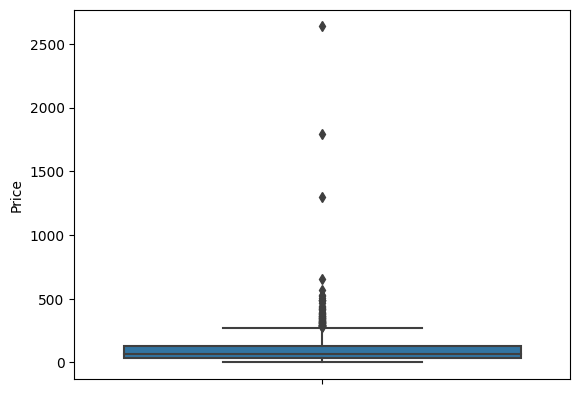

In [136]:
sns.boxplot(data = df, y='Price')

It seems that the Price column has many outliers, but the obvious ones are prices well above 1000. We can drop these observations.

In [137]:
# Find index values of observations above 1000
drop_price_outliers = df[df['Price']>1000].index
drop_price_outliers

Index([269, 407, 421], dtype='int64')

In [138]:
df.drop(drop_price_outliers, inplace=True)

In [139]:
# 3 entries dropped with 944 left
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 944 entries, 1 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Product     944 non-null    object        
 1   Region      944 non-null    object        
 2   Price       944 non-null    float64       
 3   Units Sold  944 non-null    float64       
 4   Sale Date   944 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 44.2+ KB


Let's repeat the process for Units Sold.

<Axes: ylabel='Units Sold'>

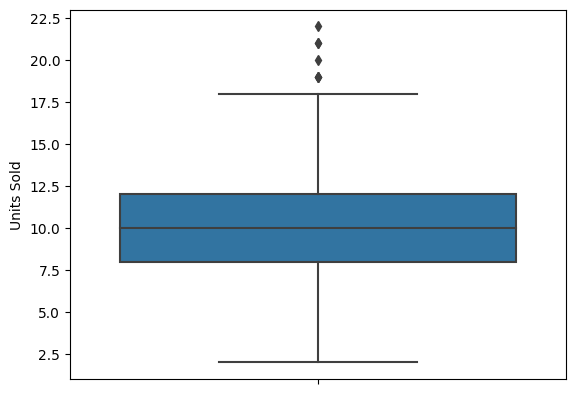

In [140]:
sns.boxplot(data = df, y = 'Units Sold')

We can drop the highest 4 entries.

In [141]:
# Find the highest entries
df['Units Sold'].sort_values(ascending=False).head(10)

559    22.0
712    21.0
436    21.0
5      20.0
97     19.0
841    19.0
939    19.0
703    18.0
350    18.0
487    18.0
Name: Units Sold, dtype: float64

In [142]:
# Since we have several duplicates of 19+ , we can now filter for any values 19+
drop_unit_outliers = df[df['Units Sold'] >= 19].index
drop_unit_outliers

Index([5, 97, 436, 559, 712, 841, 939], dtype='int64')

In [143]:
df.drop(drop_unit_outliers, inplace=True)

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 937 entries, 1 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Product     937 non-null    object        
 1   Region      937 non-null    object        
 2   Price       937 non-null    float64       
 3   Units Sold  937 non-null    float64       
 4   Sale Date   937 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 43.9+ KB


Finally, let's drop any duplicate entries.

In [145]:
df.drop_duplicates(inplace=True)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 890 entries, 1 to 998
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Product     890 non-null    object        
 1   Region      890 non-null    object        
 2   Price       890 non-null    float64       
 3   Units Sold  890 non-null    float64       
 4   Sale Date   890 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 41.7+ KB


We are now finished the data cleaning steps! Our final DataFrame has 890 entries we can use for analysis. To summarize how we approached cleaning the data:
* We dropped rows that had multiple missing values, which would cause challenges for imputation
* We reviewed missing values in detail, and compared various approaches to imputing data. For the Region, we assessed whether we should impute with "Other" or the mode - since the mode resulted in value changes, we decided to go with "Other"
* For the Product, we compared the approach of "Other", the mode, or imputing with random product assignments. Neither approach was great, and since we had only 10% of missing data points we decided that as long as we fill in missing Price and Units Sold data, we can drop the missing data from this column
* For Price, we compared imputation by the column median, median by Product, or median by Region. Option 1 and 3 yielded the same results, and Option 2 created bias - as such, we decided to use the column median
* For Units Sold, we compared imputation by the column median, median by Product, or median by Region. All 3 options yielded similar results, so for simplicity we used the column median
* We changed the data type of the Sale Date column to datetime
* We used a boxplot to identify outliers in the Price and Units Sold column, and removed outliers
* We dropped all duplicate entries

Now, let's move on to Data Exploration.

### Data Exploration

The purpose of the data exploration stage is to identify trends and patterns in data. First, we should explore each variable by itself, and then we should explore variables in pairs or combinations. Our objective for the Data Exploration stage is to identify clear patterns or recommendations we can make to the business.

Let's start with univariate analysis. 

For the continuous variables (Price and Units Sold), we can use histograms to understand spread. For categorical variables, we can use counts and bar charts to see which groups are most popular.


<Axes: xlabel='Price', ylabel='Count'>

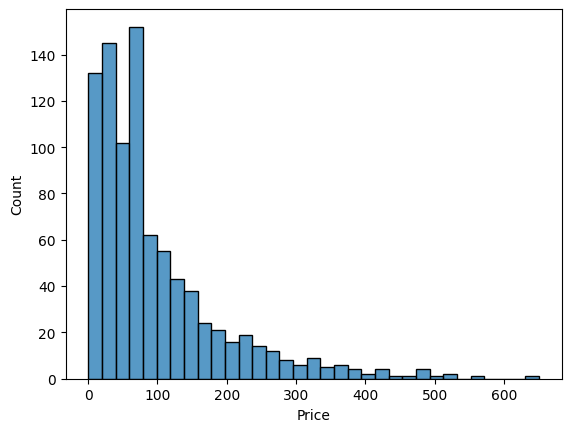

In [147]:
sns.histplot(df['Price'])

In [151]:
from scipy import stats
print(stats.skew(df['Price']))
print(stats.kurtosis(df['Price']))


1.980319992249376
4.662449853984416


<Axes: xlabel='Units Sold', ylabel='Count'>

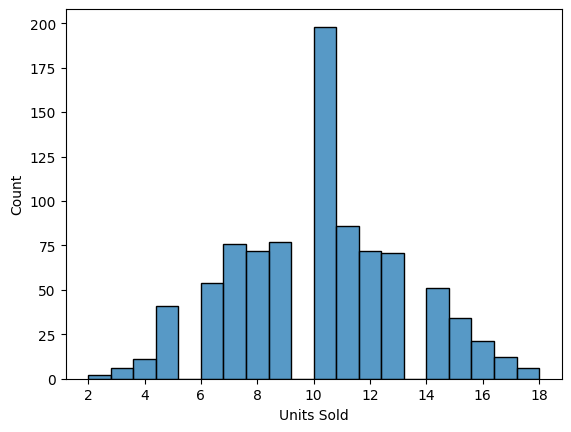

In [149]:
sns.histplot(df['Units Sold'])

In [150]:
print(stats.skew(df['Units Sold']))
print(stats.kurtosis(df['Units Sold']))

0.11525978515777988
-0.26841055861702046


Here we can see that the price has a right skew. This means that most products are lower-priced, with some products erring on the more expensive side. We can print out the Skew metric to validate what we're seeing. The skew for Price is equal to 1.94 indicating a right skew. 

the Units Sold distribution seems fairly normal, with most products selling around 10 units per transaction. The skew for Units Sold is 0.09, which is fairly close to 0 and supports what we see (normal distribution). We can also calculate kurtosis since the distribution is normal. The kurtosis of Units Sold is -0.27, which indicates a slightly Platykurtic distribution (thin tails), or less volatility.

Now let's check our categorical variables. We will look at counts to see how the data is distributed - we can use groupby() to group by the categorical variable, pick any random column to count the number of entries related to that column, aggregate with count(), sort using sort_values() and use plot() to create a bar chart. I'm adding a figsize parameter which allows me to make the figure a bit bigger and easier to see.

<Axes: xlabel='Product'>

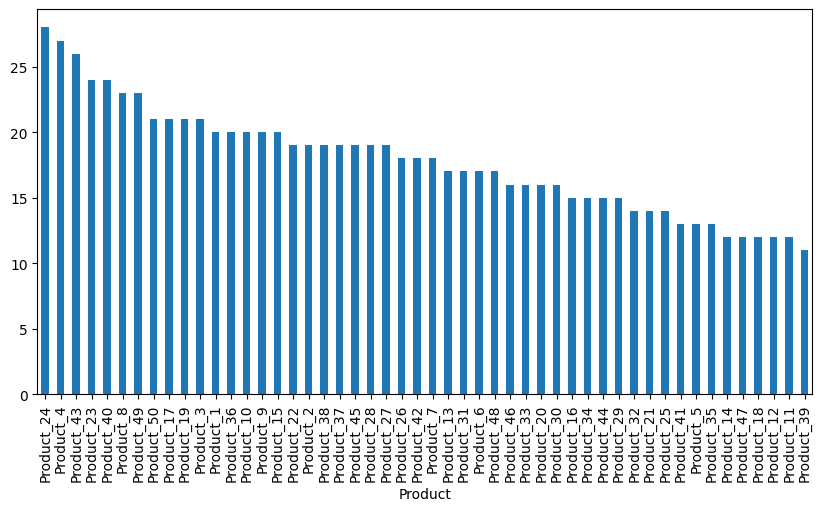

In [152]:
df.groupby('Product')['Units Sold'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

We can see that Product 24 has the highest number of transactions, followed by product 4, product 43, product 23 and product 40. On the other hand, product 39 has the least number of transactions.

<Axes: xlabel='Region'>

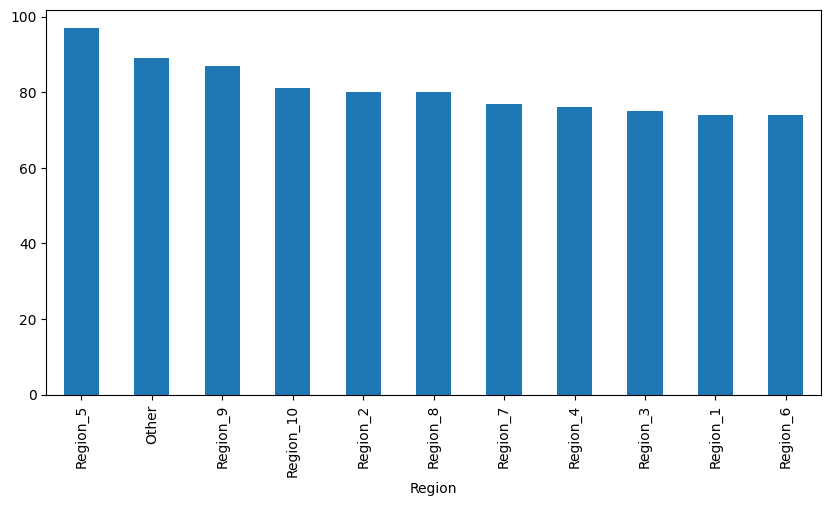

In [153]:
df.groupby('Region')['Units Sold'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

Region 5 seems to have the most transactions, followed by "Other", then Region 9. The worst 2 regions are Region 6 and Region 1.

Now we can move on to bi-variate analysis. We should analyze variables in pairs - a few things we should look at:

For Units Sold:
* Count of transactions by Region
* Count of transactions by Product
* Total number of units sold by Region
* Total number of units sold by Product
* Average number of units sold by Region
* Average number of units sold by Product
* Median number of units sold by Product
* Median number of units sold by Region

For Price:
* Average price by Product
* Relationship between Price and Units Sold


In [154]:
units_by_region = df.groupby('Region')['Units Sold'].aggregate(['sum','mean','median','count'])
units_by_region

,sum,mean,median,count
Region,,,,
Other,872.0,9.797753,10.0,89
Region_1,750.0,10.135135,10.0,74
Region_10,792.0,9.777778,10.0,81
Region_2,830.0,10.375000,10.0,80
Region_3,746.0,9.946667,10.0,75
Region_4,782.0,10.289474,10.0,76
Region_5,949.0,9.783505,10.0,97
Region_6,775.0,10.472973,10.0,74
Region_7,808.0,10.493506,10.0,77


<Axes: xlabel='Region'>

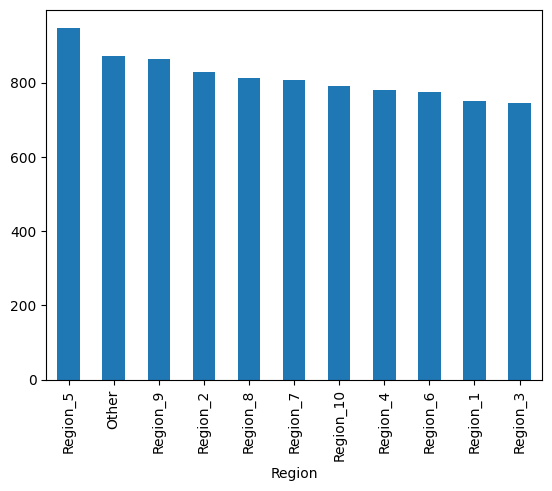

In [155]:
units_by_region['sum'].sort_values(ascending=False).plot(kind='bar')

<Axes: xlabel='Region'>

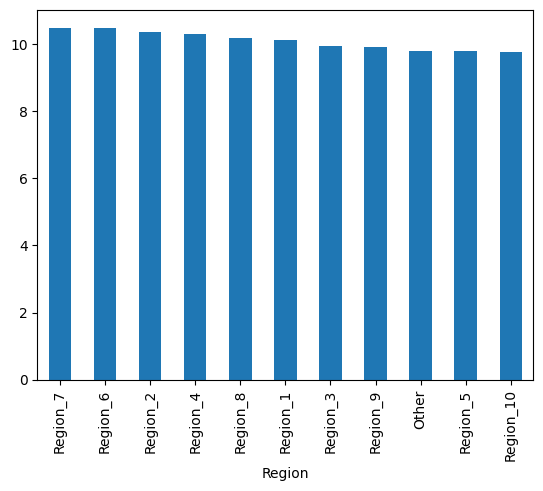

In [157]:
units_by_region['mean'].sort_values(ascending=False).plot(kind='bar')

Some initial insights:
* Region 5 sells the most units overall, while Region 3 sells the least
* Region 6 and 7 sell the highest amount of units per transaction on average, while Regions 5 and 10 sell the least

Let's review the same by Product.

In [158]:
units_by_product = df.groupby('Product')['Units Sold'].aggregate(['sum','mean','median','count'])
units_by_product.head()

,sum,mean,median,count
Product,,,,
Product_1,201.0,10.050000,10.0,20
Product_10,222.0,11.100000,11.0,20
Product_11,130.0,10.833333,11.0,12
Product_12,121.0,10.083333,10.0,12
Product_13,181.0,10.647059,10.0,17


<Axes: xlabel='Product'>

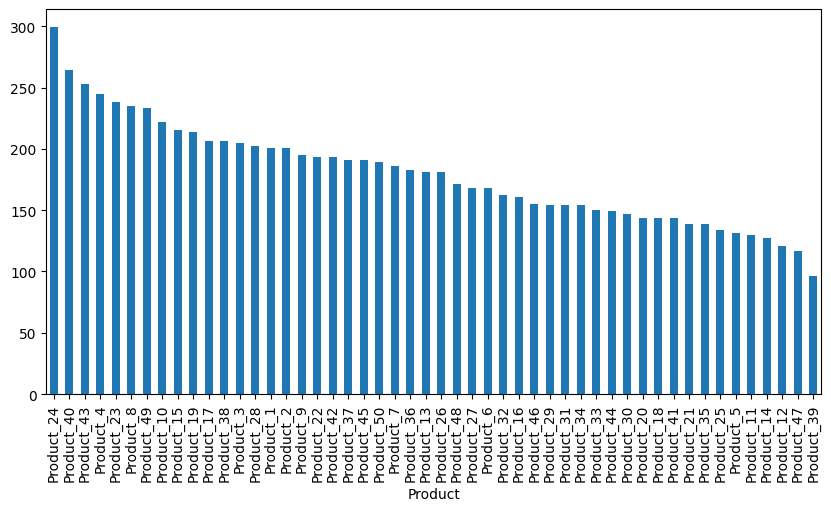

In [159]:
units_by_product['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<Axes: xlabel='Product'>

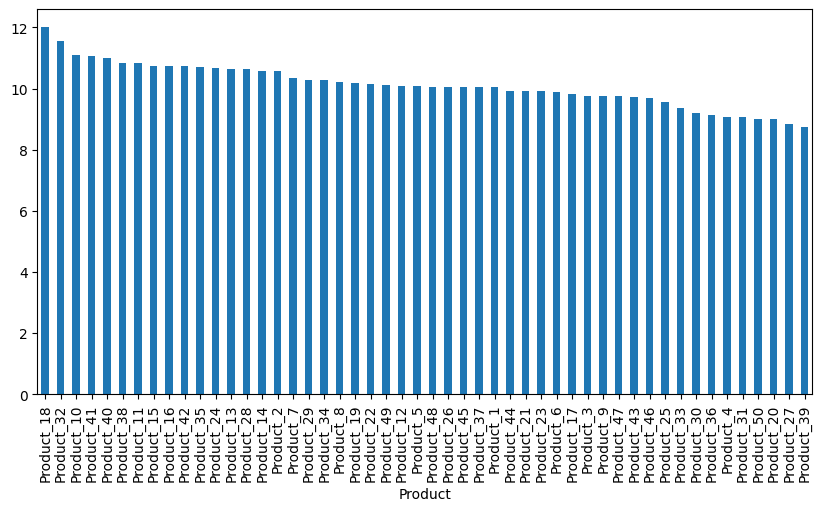

In [162]:
units_by_product['mean'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

Some initial insights:
* Product 24 has the highest overall units sold, while Product 39 has the least
* Product 18 sells the highest average units per transaction, while Product 39 sells the least

Now let's look at the average price per product

<Axes: xlabel='Product'>

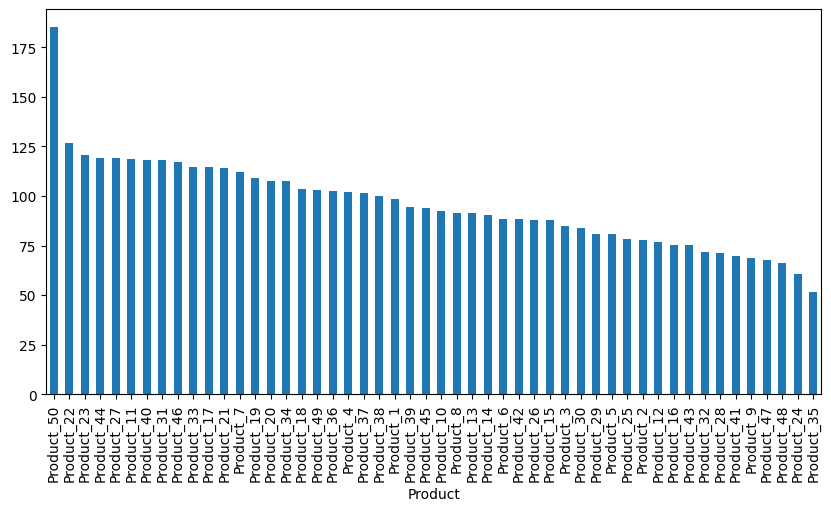

In [163]:
df.groupby('Product')['Price'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

We can see that Product 50 has the highest price; Product 39, while it sells the least, does not have the lowest price. The price on average is somewhere in the middle. Now let's compare price and units.

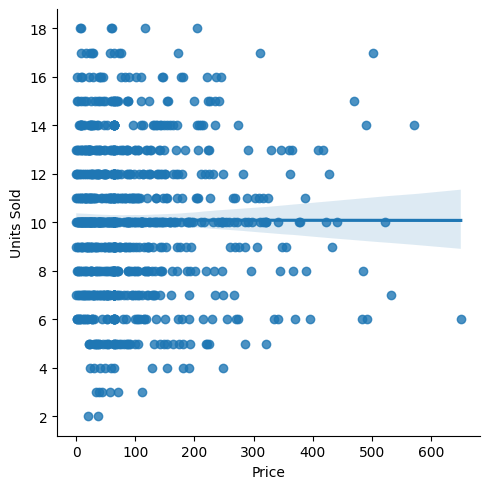

In [164]:
sns.lmplot(data = df, x='Price', y='Units Sold')

We can see that the relatonship between Price and Units Sold is fairly flat. This indicates that Price is not a decision driver for units sold - in other words, a lower or higher price doesn't influence the amount of units sold. There must be low sensitivity to price.

Now that we are done the bi-variate analysis, we can move on to multivariate. We should anchor our analysis on understanding each region. First, we should create a new column which calculates the total revenue for each transaction (Price * Units Sold). Then, we can analyze each region one by one in order to identify opportunities for the business.

In [165]:
# Create total Revenue column
df['Revenue'] = df['Price'] * df['Units Sold']

#### Region 1

The following is the Region 1 analysis. We are going to first filter the dataframe for Region 1, then aggregate the Price, Units Sold and Revenue. For Price, we are interested in the average price by product. For Units Sold and Revenue, we would like to see Averages and Totals.

In [166]:
region_1 = df[df['Region']=='Region_1'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

<Axes: xlabel='Product'>

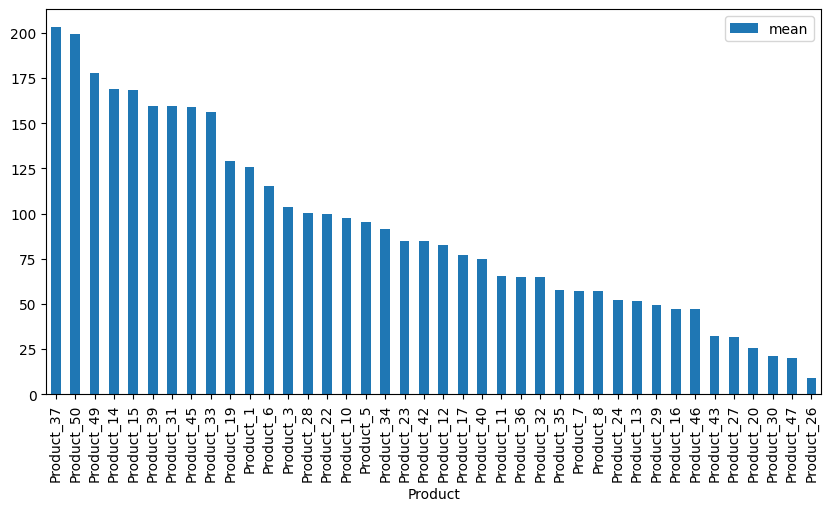

In [168]:
region_1['Price'].sort_values('mean',ascending=False).plot(kind='bar', figsize=(10,5))

<Axes: xlabel='Product'>

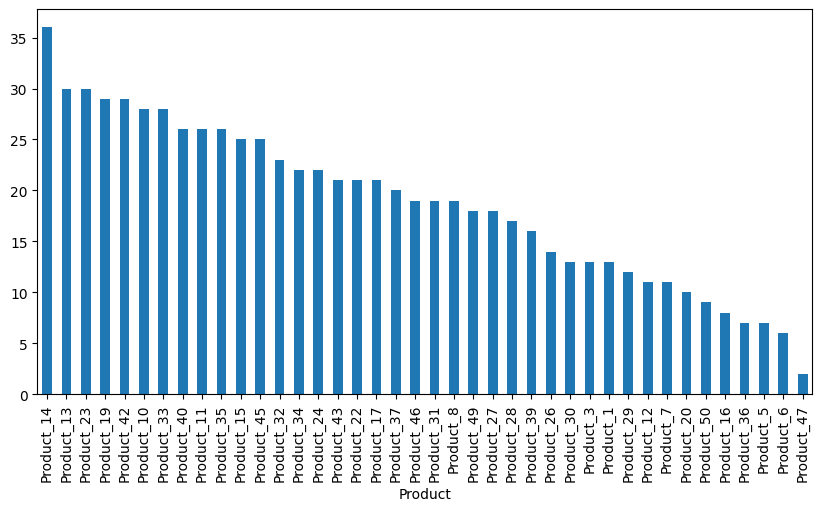

In [169]:
region_1['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<Axes: xlabel='Product'>

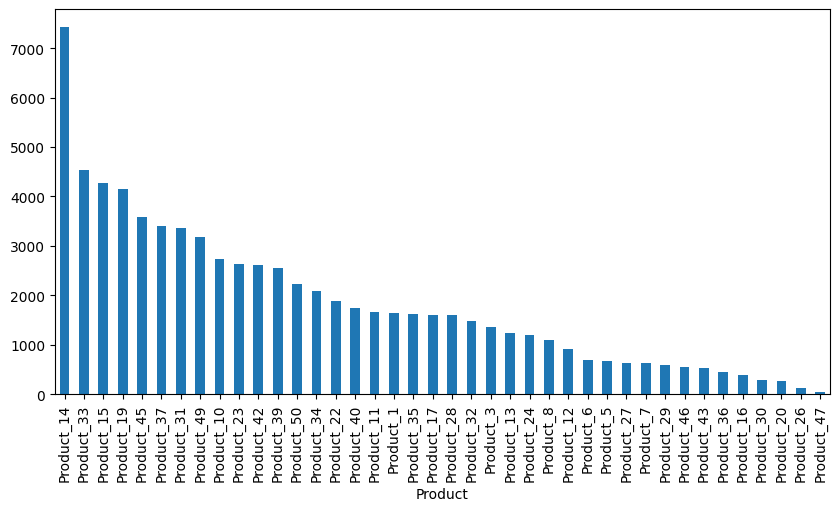

In [170]:
region_1['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

#### Region 1 Summary

* Product 14 yields the highest revenue, with the highest number of units sold
* Product 37 is the most expensive, and yields the 6th highest revenue
* Product 47 offers the least revenue, the least units sold, and has a low price
* Product 26 has the lowest price and second lowest revenue

Generally, we could recommend that Region 1 should stop selling Products 47 and 26. It should try to upsell Product 37 to increase profitability.

#### Region 2
Let's move on to Region 2

In [171]:
region_2 = df[df['Region']=='Region_2'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

<Axes: xlabel='Product'>

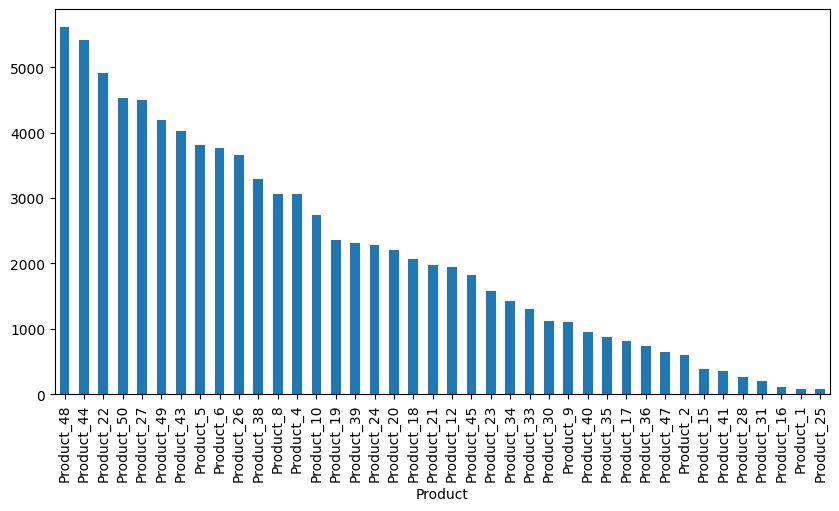

In [172]:
region_2['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<Axes: xlabel='Product'>

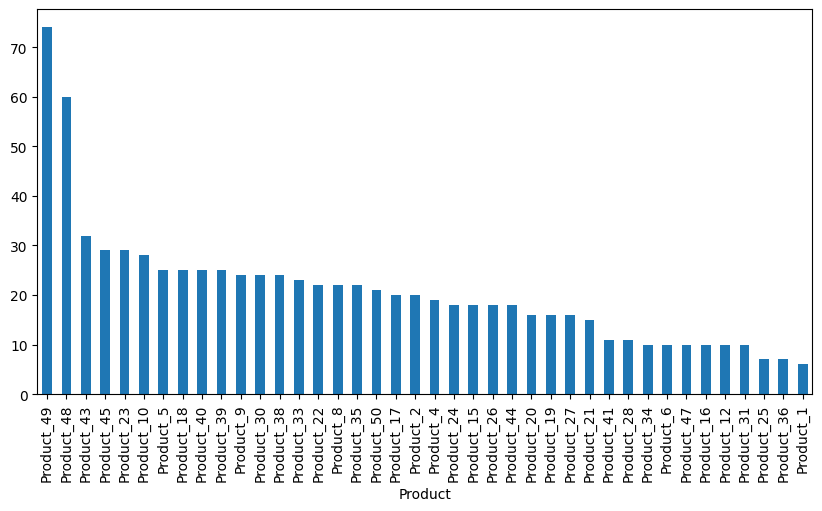

In [173]:
region_2['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

* Products 48 and 49 have the most units sold
* While Product 49 has the 4th highest revenue, it sells the most units
* Product 22 has high revenues, but low volume - which indicates the price must be higher
* Product 1 and Product 25 have low volume and do not make much revenue

Since customers are not price sensitive, we could recommend the company increase the price on Product 49 to increase overall Revenue. This region should stop selling Products 1 and 25.

#### Region 3
Let's move on to Region 3.

In [174]:
region_3 = df[df['Region']=='Region_3'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

<Axes: xlabel='Product'>

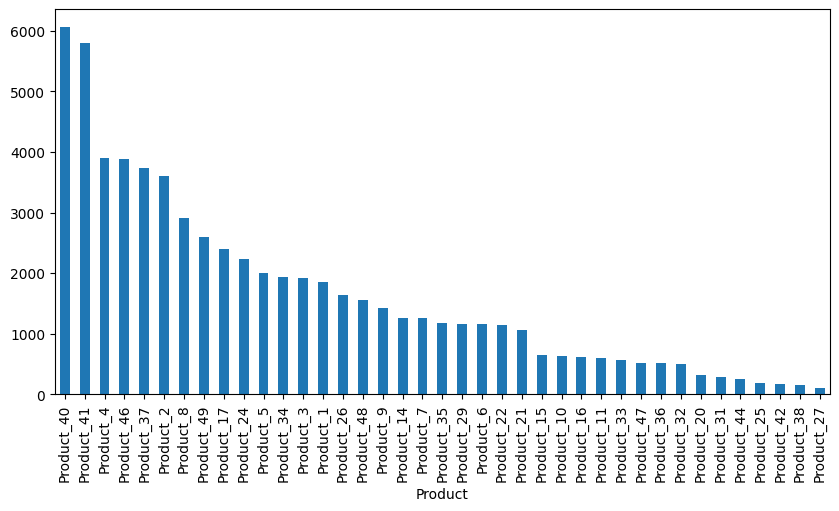

In [175]:
region_3['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<Axes: xlabel='Product'>

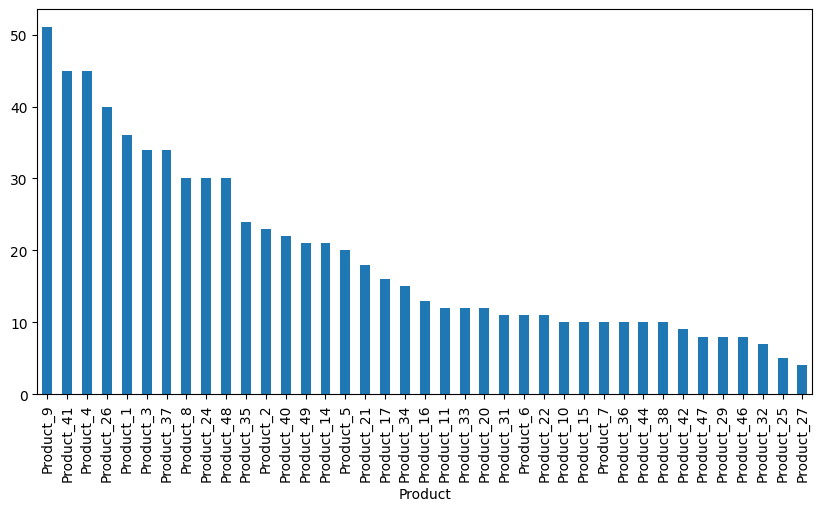

In [176]:
region_3['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

* Products 40 and 41 have the highest revenue; Product 41 has good volume, but product 40 has medium volume
* Product 27 has low revenue and low volume, and so does Product 25

We can recommend an increased investment in Product 40, and removal of products 27 and 25

#### Region 4

Let's review region 4

In [177]:
region_4 = df[df['Region']=='Region_4'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

In the following example, I'm using the matplotlib library and specifically the subplots() function to create 2 plots next to each other. This can save me some time with coding the Revenue and Volume plots for each region. I'm also adding a title parameter to the plot() function to add titles to each plot.

<Axes: title={'center': 'Volume'}, xlabel='Product'>

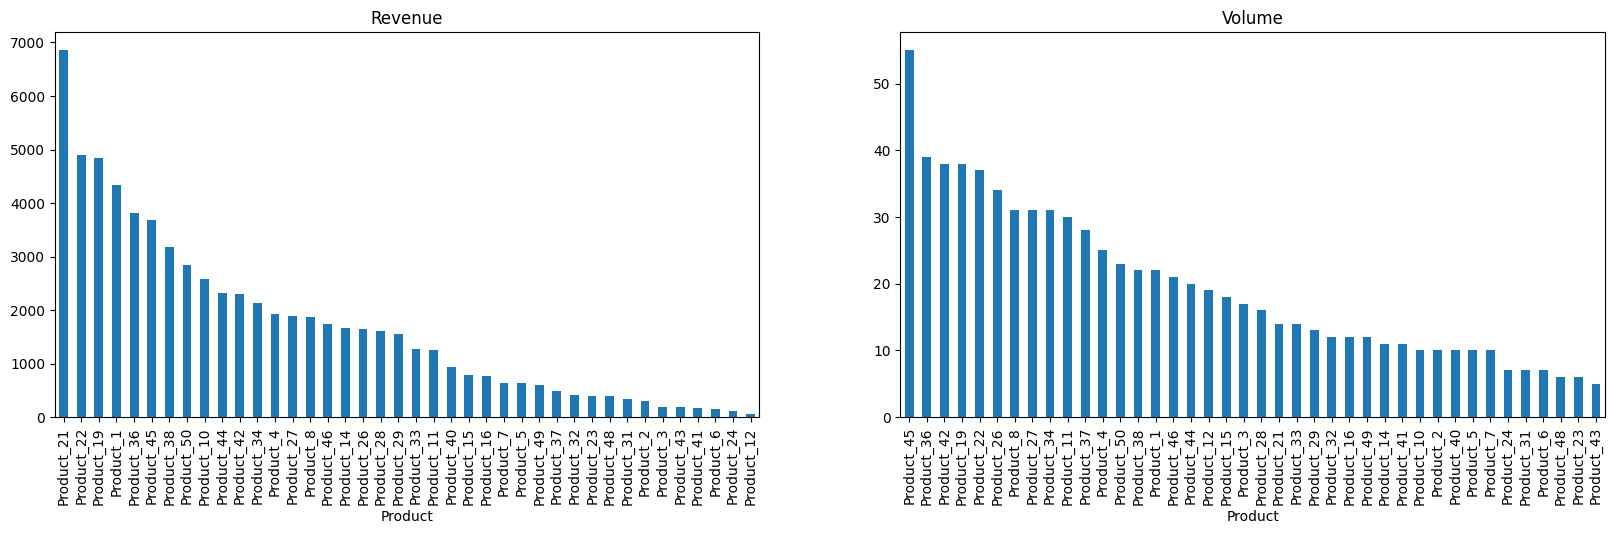

In [178]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_4['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_4['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations: 
* Products 6 and 43 has low volume, and low revenue and should be removed
* Product 12 has very low revenue, but medium volume so we should increase the price
* Product 21 has high revenue and medium volume, so we should try to increase volume
* Product 19 has high revenue and high volume, increasing the price could make it a higher-revenue product

#### Region 5

Let's look at region 5 next. We can also bring all the code together in 1 cell.


<Axes: title={'center': 'Volume'}, xlabel='Product'>

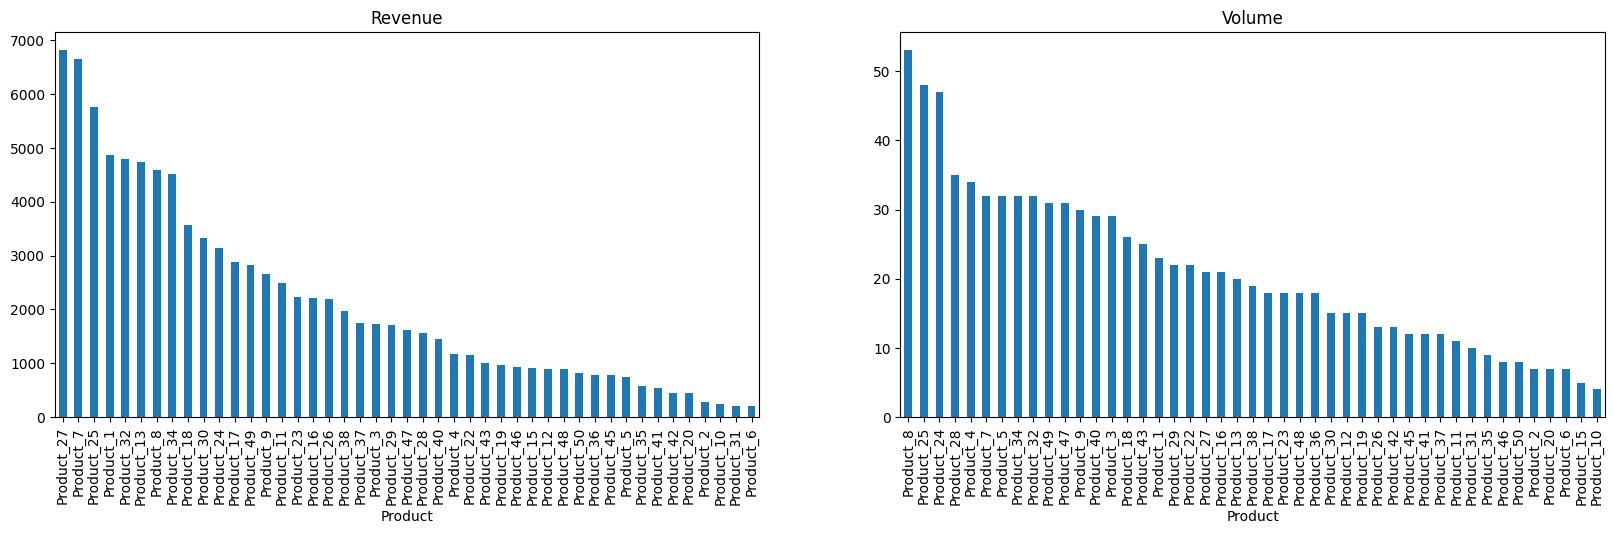

In [179]:
region_5 = df[df['Region']=='Region_5'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_5['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_5['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations:
* Product 6 has low volume, and low revenue - we should remove this one
* Product 10 haas low volmue and low revenue - we should remove this one
* Product 27 has high revenue and medium volume - we should aim to increase sales
* Product 7 has high revenue and medium volume - we could increase the volume or price
* Product 8 has high volume and medium revenue - we should increase the price

#### Region 6
Let's review region 6 next

<Axes: title={'center': 'Volume'}, xlabel='Product'>

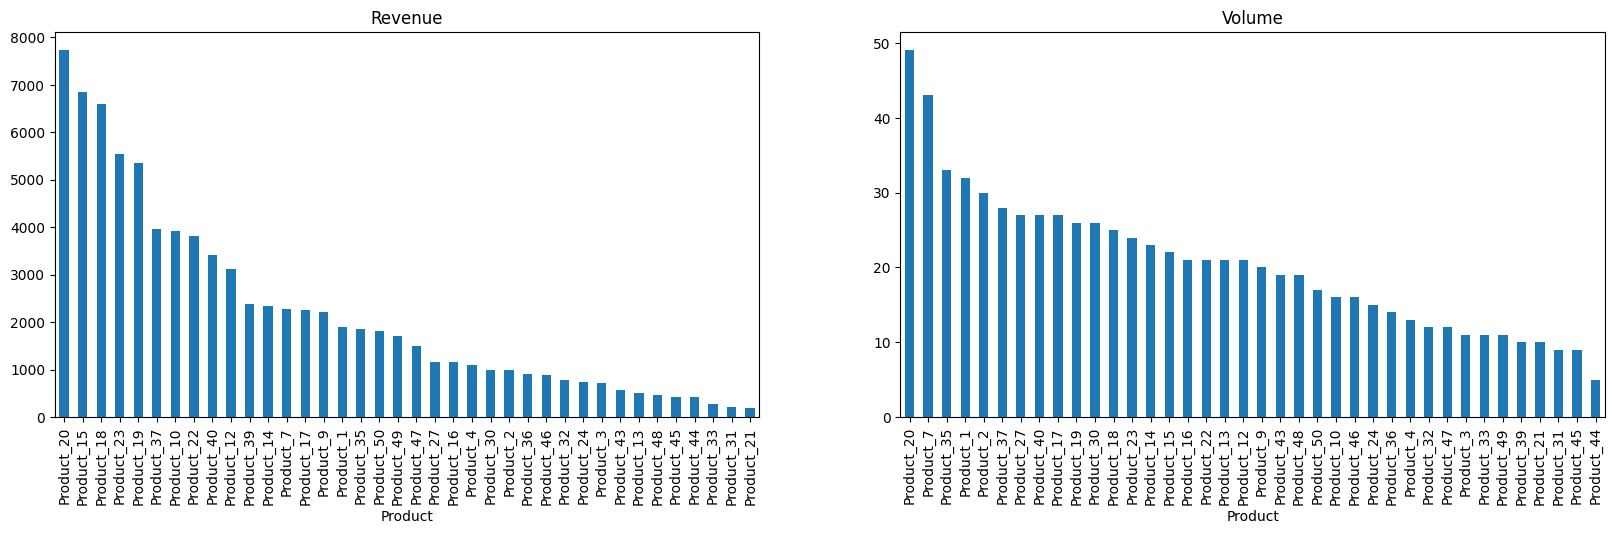

In [180]:
region_6 = df[df['Region']=='Region_6'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_6['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_6['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations:
* Product 20 has the highest volume and revenue, we should keep this as is
* Product 15 has high revenue but medium volume - we should try to increase the volume
* Products 31, 44, 45 have low revenues and low volume and should be removed
* Product 37 has high volume, but low revenue - we should increase the price

#### Region 7

Let's review region 7

<Axes: title={'center': 'Volume'}, xlabel='Product'>

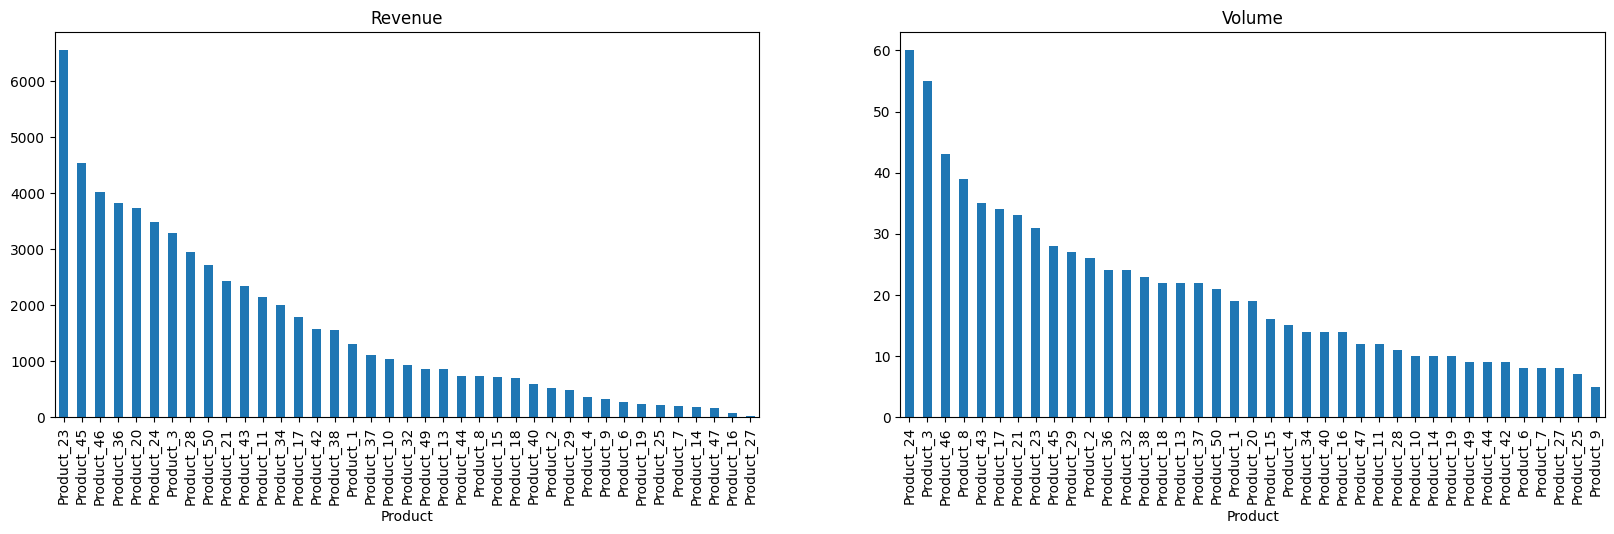

In [181]:
region_7 = df[df['Region']=='Region_7'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_7['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_7['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations:
* Product 27 has very low revenue and volume, and should be removed, along with product 7
* Product 24 has high volume, and somewhat high revenue - we should increase the price
* Product 23 has the highest revenue, and medium volume - we should try to increase the volume
* Product 3 has high volume, but medium revenue - we should increase the price

#### Region 8

<Axes: title={'center': 'Volume'}, xlabel='Product'>

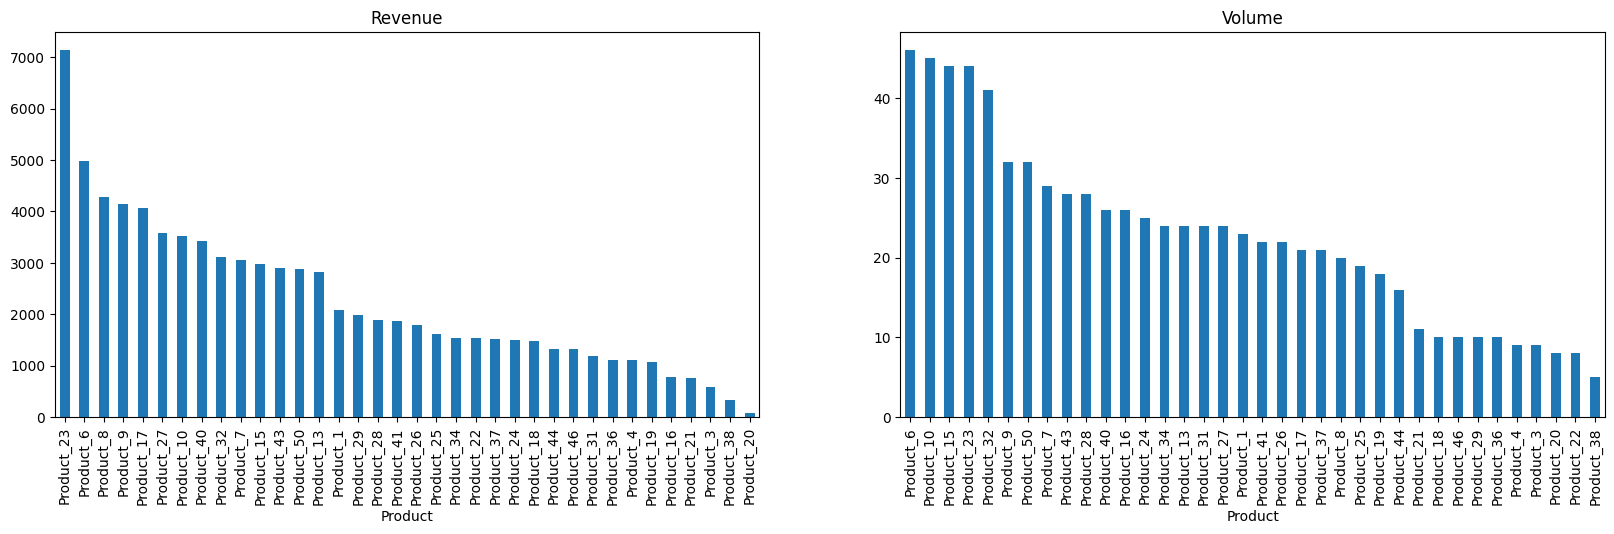

In [182]:
region_8 = df[df['Region']=='Region_8'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_8['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_8['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations:
* Product 38 and Product 20 should be removed as they are low performing
* Product 23 has the highest revenue and has fairly high volume; keep as is
* Product 6 could use a price increase to improve revenue
* Product 10 could use a price increase to improve revenue

<Axes: title={'center': 'Volume'}, xlabel='Product'>

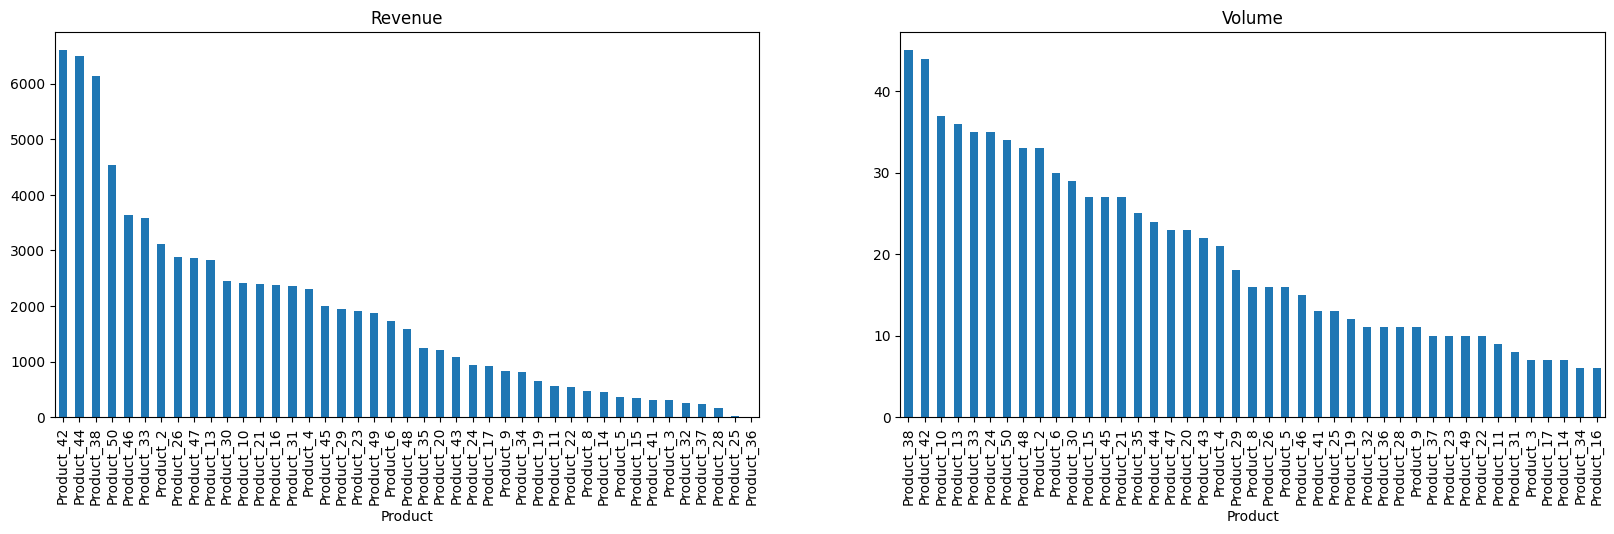

In [183]:
region_9 = df[df['Region']=='Region_9'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_9['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_9['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations:
* Product 42 has high volume, and high revenue - keep as is
* Product 38 could use a minor price increase
* Products 25, 28, 32, 36, 37, 41 have medium volume, but almost no revenue - it either needs to be removed or it needs a price increase
* Product 3 could be dropped due to lower volume and low revenue

<Axes: title={'center': 'Volume'}, xlabel='Product'>

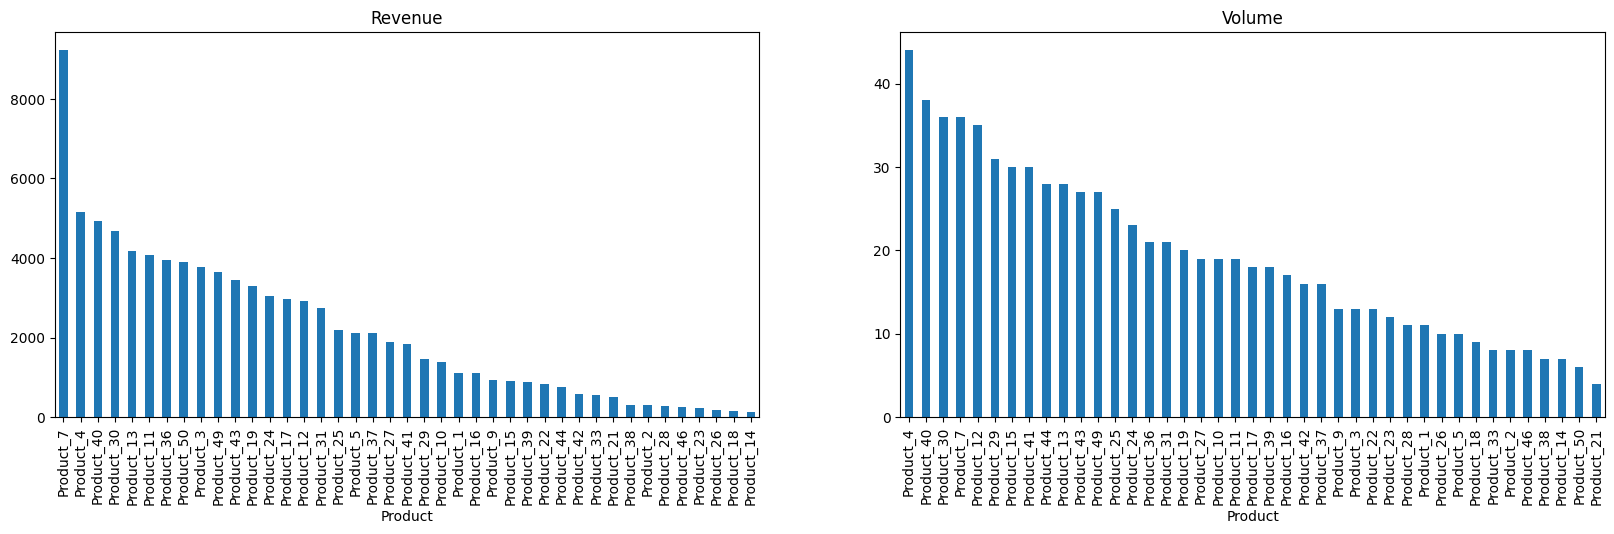

In [184]:
region_10 = df[df['Region']=='Region_10'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

region_10['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax1, title='Revenue')
region_10['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', ax=ax2, title='Volume')

Recommendations:
* Product 4 has high volume, and could use a price increase
* Product 7 is very profitable and could use a volume increase
* Products 14, 46, 23, 18 have medium volume and could use a price increase


## Final Thoughts
Now we have completed the analysis. We have identified 3-5 actionable recommendations for each region. We took a region-first approach to this analysis because we are looking at an overall company strategy, however you could also look at individual product performance for each region, if you are looking at a product strategy. You will notice that the code often repeats itself, and what we should always focus on with this type of analysis is depth actionable recommendations.